100%|██████████| 100/100 [01:01<00:00,  1.62it/s]


Original shape: torch.Size([10, 1028, 1028])
Super-resolved (downsampled) shape: torch.Size([10, 1028, 1028])


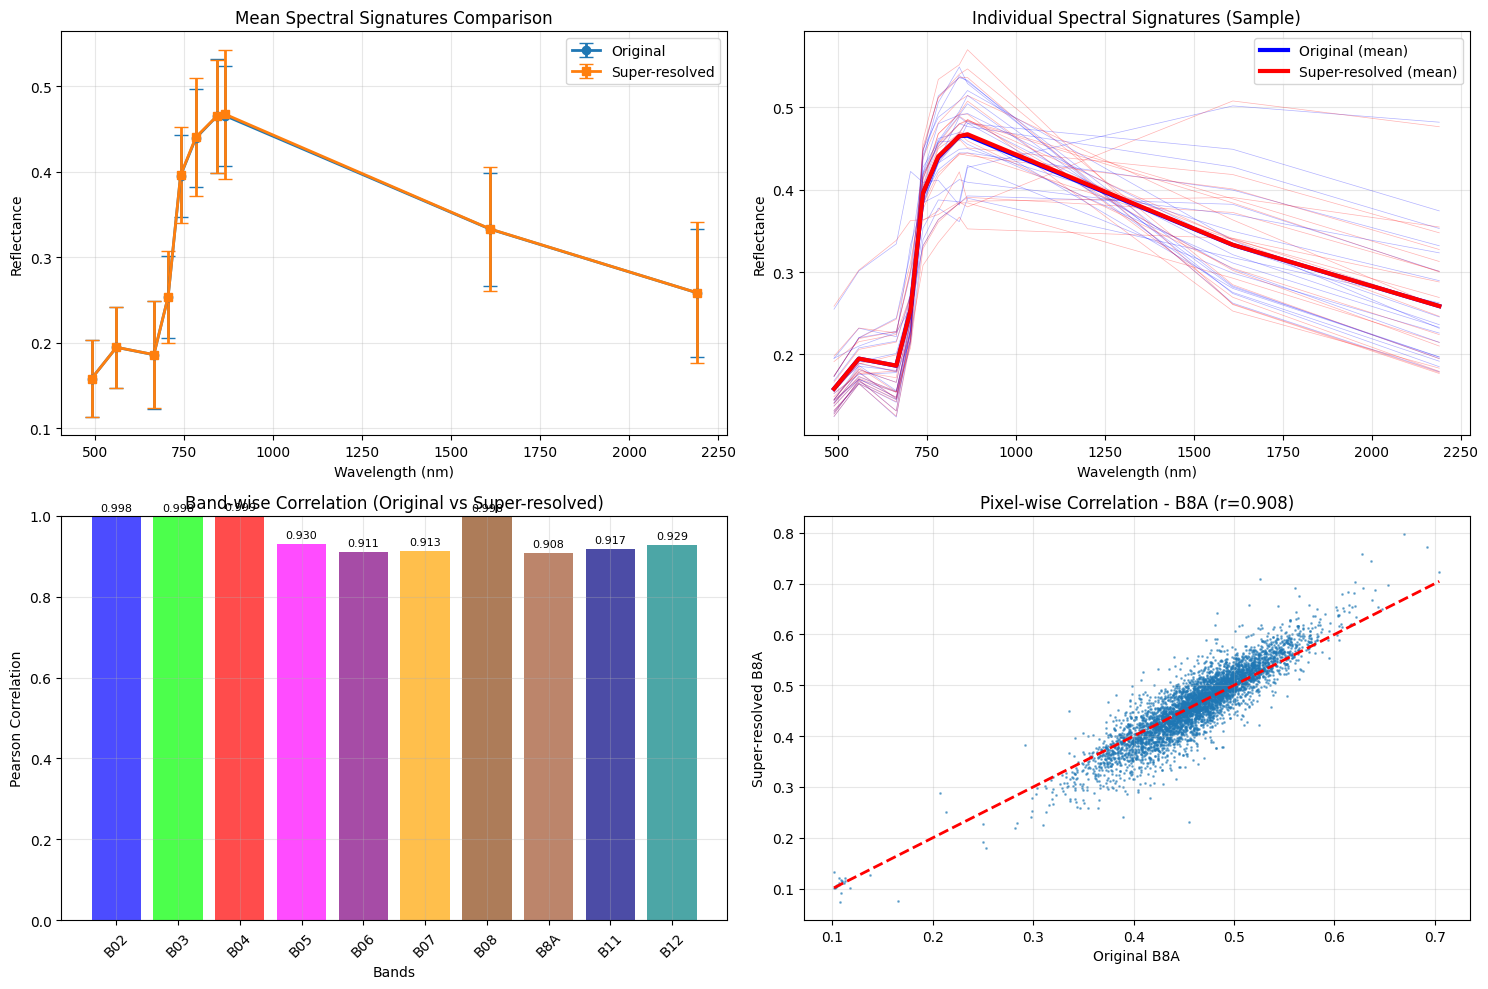

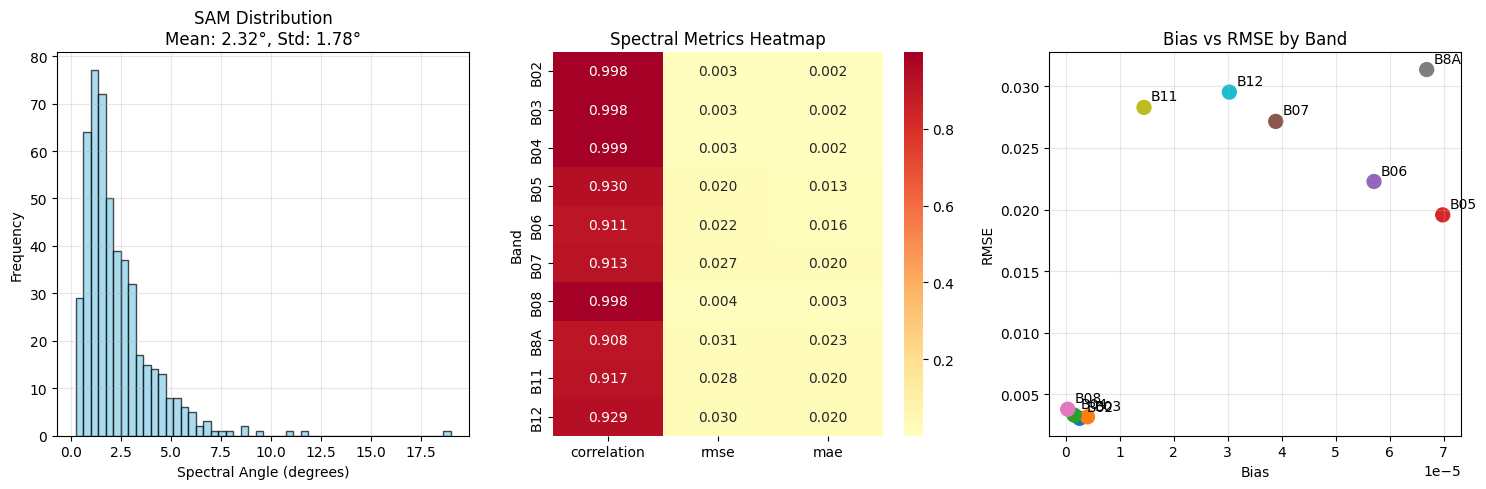

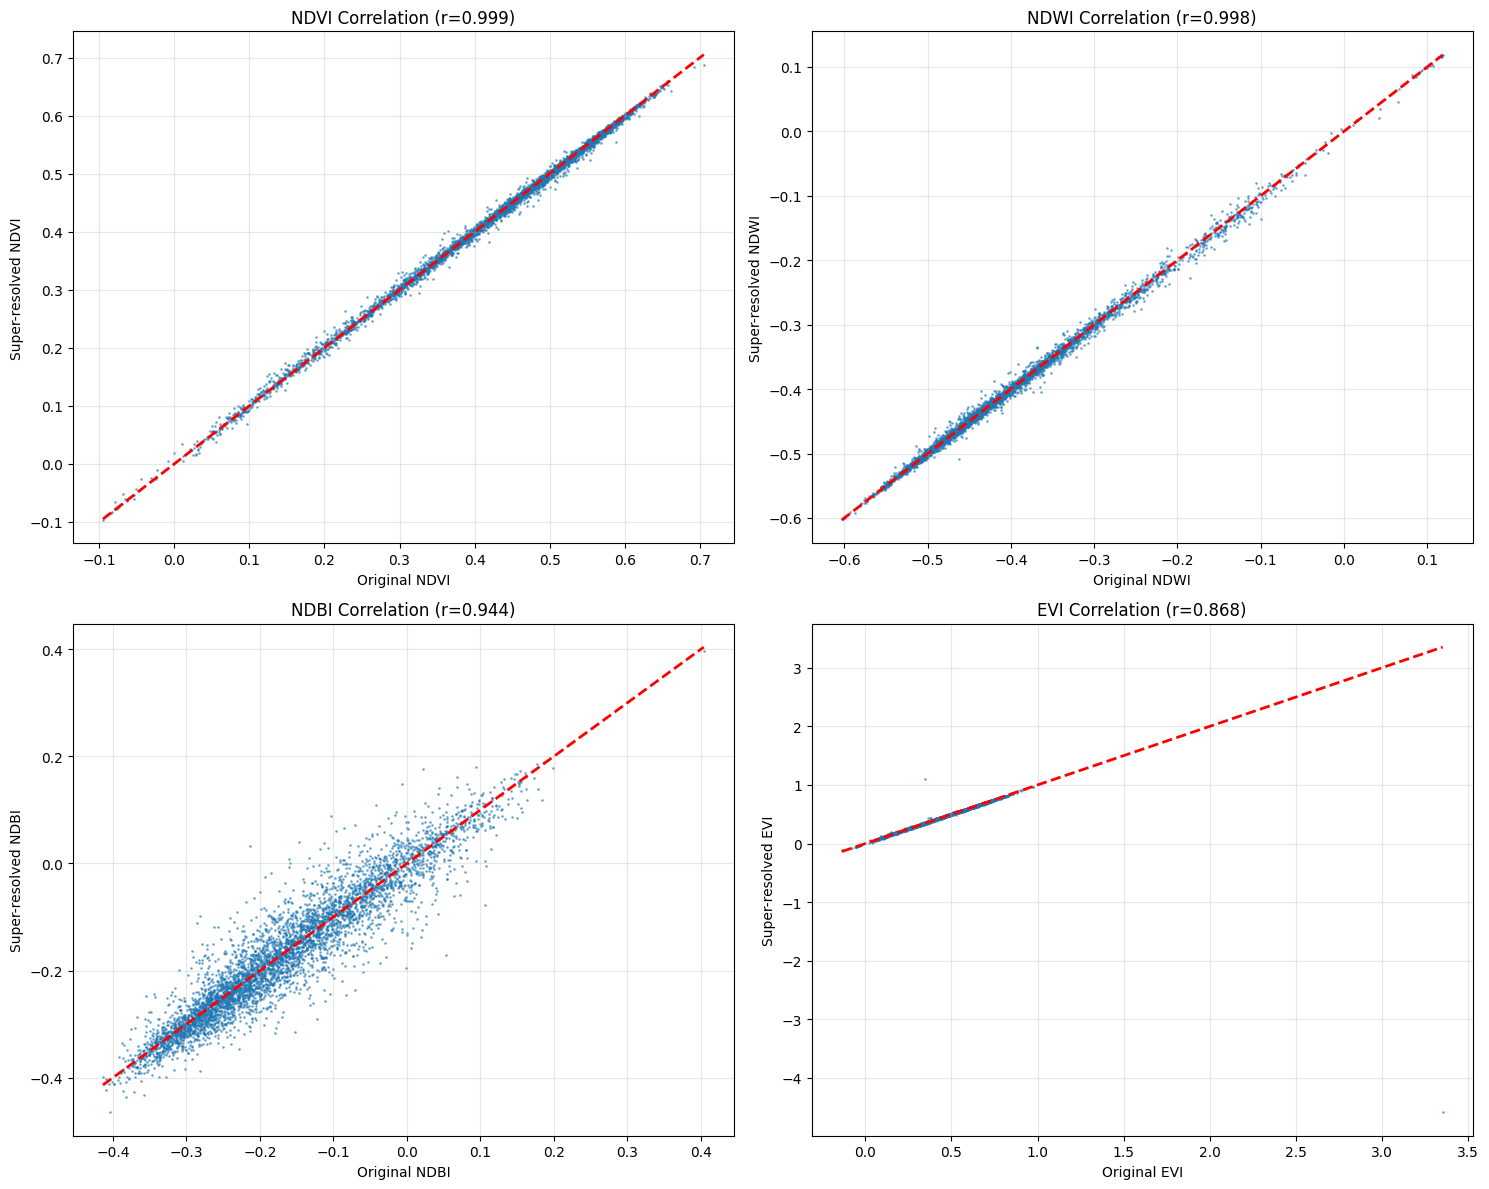


SPECTRAL PRESERVATION ANALYSIS SUMMARY

Overall Statistics:
Mean Spectral Angle Mapper (SAM): 2.321° ± 1.782°
Median SAM: 1.782°
95th percentile SAM: 5.491°

Band-wise Correlations:
B02 (490nm): r = 0.9978
B03 (560nm): r = 0.9979
B04 (665nm): r = 0.9986
B05 (705nm): r = 0.9298
B06 (740nm): r = 0.9111
B07 (783nm): r = 0.9135
B08 (842nm): r = 0.9983
B8A (865nm): r = 0.9079
B11 (1610nm): r = 0.9174
B12 (2190nm): r = 0.9289

Spectral Indices Correlations:
NDVI: r = 0.9991
NDWI: r = 0.9985
NDBI: r = 0.9435
EVI: r = 0.8676

Detailed Band Metrics:
      correlation    rmse     mae    bias  relative_bias
Band                                                    
B02        0.9978  0.0030  0.0017  0.0000         0.0016
B03        0.9979  0.0032  0.0018  0.0000         0.0021
B04        0.9986  0.0033  0.0019  0.0000         0.0008
B05        0.9298  0.0196  0.0129  0.0001         0.0275
B06        0.9111  0.0223  0.0161  0.0001         0.0145
B07        0.9135  0.0272  0.0199  0.0000         0.0

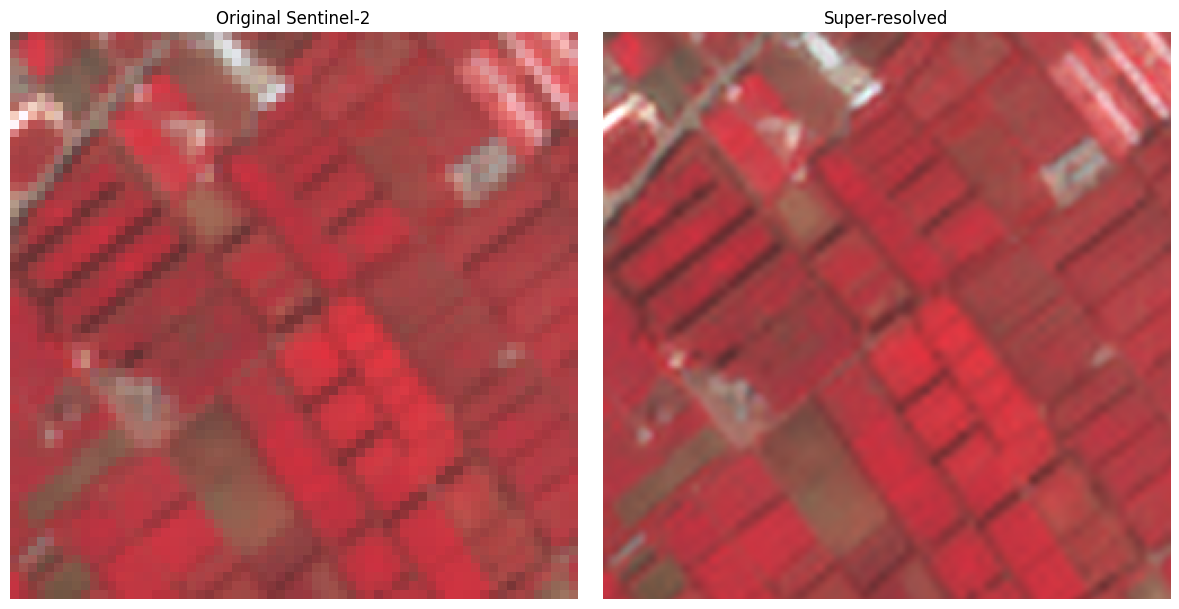


Analysis completed! The algorithm shows:
- Average spectral correlation: 0.950
- Average spectral angle: 2.32°
- Best preserved band: B04 (r=0.999)
- Worst preserved band: B8A (r=0.908)


In [1]:
import mlstac
import torch
import cubo
import sen2sr
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Load the model
model_dir = r"model\sen2sr"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = mlstac.load(model_dir).compiled_model(device=device)
model = model.to(device)

# Create a Sentinel-2 L2A data cube for a specific location and date range
da = cubo.create(
    lat=36.680079,
    lon=10.583995,
    collection="sentinel-2-l2a",
    bands=["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"],
    start_date="2025-04-01",
    end_date="2025-06-05",
    edge_size=1028,
    resolution=10
)

# Prepare the data to be used in the model, select just one sample
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
original_s2_numpy = (da[1].compute().to_numpy() / 10_000).astype("float32")
X = torch.from_numpy(original_s2_numpy).float().to(device)

# Apply model
superX = sen2sr.predict_large(
    model=model,
    X=X,
    overlap=16,
)



# Define band names and wavelengths for better visualization
band_names = ["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]
band_wavelengths = [490, 560, 665, 705, 740, 783, 842, 865, 1610, 2190]  # in nm
band_colors = ['#0000FF', '#00FF00', '#FF0000', '#FF00FF', '#800080', '#FFA500', '#8B4513', '#A0522D', '#000080', '#008080']

# ============================================================================
# SPECTRAL PRESERVATION ANALYSIS
# ============================================================================

def downsample_for_comparison(hr_tensor, factor=4):
    """Downsample high-res tensor to match original resolution for comparison"""
    # Use average pooling to downsample
    downsampled = torch.nn.functional.avg_pool2d(hr_tensor, kernel_size=factor, stride=factor)
    return downsampled

# Downsample super-resolved image for pixel-wise comparison
superX_downsampled = downsample_for_comparison(superX)

# Ensure same spatial dimensions for comparison
min_h = min(X.shape[1], superX_downsampled.shape[1])
min_w = min(X.shape[2], superX_downsampled.shape[2])
X_crop = X[:, :min_h, :min_w]
superX_down_crop = superX_downsampled[:, :min_h, :min_w]

print(f"Original shape: {X_crop.shape}")
print(f"Super-resolved (downsampled) shape: {superX_down_crop.shape}")

# ============================================================================
# 1. SPECTRAL SIGNATURE COMPARISON
# ============================================================================

# Extract spectral signatures from different regions
def extract_spectral_signatures(tensor, num_samples=500):
    """Extract random spectral signatures from the image"""
    c, h, w = tensor.shape
    signatures = []
    
    # Random sampling
    np.random.seed(42)  # For reproducibility
    for _ in range(num_samples):
        i = np.random.randint(0, h)
        j = np.random.randint(0, w)
        signature = tensor[:, i, j].cpu().numpy()
        signatures.append(signature)
    
    return np.array(signatures)

# Extract signatures
original_signatures = extract_spectral_signatures(X_crop)
super_signatures = extract_spectral_signatures(superX_down_crop)

# Plot spectral signatures comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot mean signatures with error bars
mean_original = np.mean(original_signatures, axis=0)
std_original = np.std(original_signatures, axis=0)
mean_super = np.mean(super_signatures, axis=0)
std_super = np.std(super_signatures, axis=0)

axes[0, 0].errorbar(band_wavelengths, mean_original, yerr=std_original, 
                   label='Original', capsize=5, marker='o', linewidth=2)
axes[0, 0].errorbar(band_wavelengths, mean_super, yerr=std_super, 
                   label='Super-resolved', capsize=5, marker='s', linewidth=2)
axes[0, 0].set_xlabel('Wavelength (nm)')
axes[0, 0].set_ylabel('Reflectance')
axes[0, 0].set_title('Mean Spectral Signatures Comparison')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot individual signatures (sample)
for i in range(min(20, len(original_signatures))):
    axes[0, 1].plot(band_wavelengths, original_signatures[i], 'b-', alpha=0.3, linewidth=0.5)
    axes[0, 1].plot(band_wavelengths, super_signatures[i], 'r-', alpha=0.3, linewidth=0.5)

axes[0, 1].plot(band_wavelengths, mean_original, 'b-', linewidth=3, label='Original (mean)')
axes[0, 1].plot(band_wavelengths, mean_super, 'r-', linewidth=3, label='Super-resolved (mean)')
axes[0, 1].set_xlabel('Wavelength (nm)')
axes[0, 1].set_ylabel('Reflectance')
axes[0, 1].set_title('Individual Spectral Signatures (Sample)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# ============================================================================
# 2. BAND-WISE CORRELATION ANALYSIS
# ============================================================================

correlations = []
for band in range(X_crop.shape[0]):
    orig_band = X_crop[band].cpu().numpy().flatten()
    super_band = superX_down_crop[band].cpu().numpy().flatten()
    corr, p_value = stats.pearsonr(orig_band, super_band)
    correlations.append(corr)

axes[1, 0].bar(range(len(band_names)), correlations, color=band_colors, alpha=0.7)
axes[1, 0].set_xlabel('Bands')
axes[1, 0].set_ylabel('Pearson Correlation')
axes[1, 0].set_title('Band-wise Correlation (Original vs Super-resolved)')
axes[1, 0].set_xticks(range(len(band_names)))
axes[1, 0].set_xticklabels(band_names, rotation=45)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim([0, 1])

# Add correlation values on bars
for i, corr in enumerate(correlations):
    axes[1, 0].text(i, corr + 0.01, f'{corr:.3f}', ha='center', va='bottom', fontsize=8)

# ============================================================================
# 3. SCATTER PLOTS FOR BAND CORRELATIONS
# ============================================================================

# Create scatter plot for the band with lowest correlation
worst_band_idx = np.argmin(correlations)
orig_worst = X_crop[worst_band_idx].cpu().numpy().flatten()
super_worst = superX_down_crop[worst_band_idx].cpu().numpy().flatten()

# Sample points for visualization (to avoid overcrowding)
sample_indices = np.random.choice(len(orig_worst), size=min(5000, len(orig_worst)), replace=False)
orig_sample = orig_worst[sample_indices]
super_sample = super_worst[sample_indices]

axes[1, 1].scatter(orig_sample, super_sample, alpha=0.5, s=1)
axes[1, 1].plot([orig_sample.min(), orig_sample.max()], 
               [orig_sample.min(), orig_sample.max()], 'r--', linewidth=2)
axes[1, 1].set_xlabel(f'Original {band_names[worst_band_idx]}')
axes[1, 1].set_ylabel(f'Super-resolved {band_names[worst_band_idx]}')
axes[1, 1].set_title(f'Pixel-wise Correlation - {band_names[worst_band_idx]} (r={correlations[worst_band_idx]:.3f})')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# 4. SPECTRAL ANGLE MAPPER (SAM) ANALYSIS
# ============================================================================

def spectral_angle_mapper(sig1, sig2):
    """Calculate Spectral Angle Mapper between two spectral signatures"""
    dot_product = np.dot(sig1, sig2)
    norm1 = np.linalg.norm(sig1)
    norm2 = np.linalg.norm(sig2)
    
    if norm1 == 0 or norm2 == 0:
        return np.pi / 2  # 90 degrees for zero vectors
    
    cos_angle = dot_product / (norm1 * norm2)
    cos_angle = np.clip(cos_angle, -1, 1)  # Handle numerical errors
    angle = np.arccos(cos_angle)
    return angle

# Calculate SAM for all pixel pairs
sam_values = []
for i in range(original_signatures.shape[0]):
    sam = spectral_angle_mapper(original_signatures[i], super_signatures[i])
    sam_values.append(np.degrees(sam))  # Convert to degrees

sam_values = np.array(sam_values)

# Plot SAM distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(sam_values, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Spectral Angle (degrees)')
plt.ylabel('Frequency')
plt.title(f'SAM Distribution\nMean: {np.mean(sam_values):.2f}°, Std: {np.std(sam_values):.2f}°')
plt.grid(True, alpha=0.3)

# ============================================================================
# 5. SPECTRAL METRICS SUMMARY
# ============================================================================

# Calculate various spectral metrics
spectral_metrics = {}

for band_idx, band_name in enumerate(band_names):
    orig_band = X_crop[band_idx].cpu().numpy().flatten()
    super_band = superX_down_crop[band_idx].cpu().numpy().flatten()
    
    spectral_metrics[band_name] = {
        'correlation': stats.pearsonr(orig_band, super_band)[0],
        'rmse': np.sqrt(mean_squared_error(orig_band, super_band)),
        'mae': mean_absolute_error(orig_band, super_band),
        'bias': np.mean(super_band - orig_band),
        'relative_bias': np.mean(super_band - orig_band) / np.mean(orig_band) * 100
    }

# Create metrics visualization
metrics_df = pd.DataFrame(spectral_metrics).T
metrics_df.index.name = 'Band'

plt.subplot(1, 3, 2)
sns.heatmap(metrics_df[['correlation', 'rmse', 'mae']], 
            annot=True, fmt='.3f', cmap='RdYlBu_r', center=0)
plt.title('Spectral Metrics Heatmap')

plt.subplot(1, 3, 3)
plt.scatter(metrics_df['bias'], metrics_df['rmse'], 
           c=range(len(band_names)), cmap='tab10', s=100)
for i, band in enumerate(band_names):
    plt.annotate(band, (metrics_df.iloc[i]['bias'], metrics_df.iloc[i]['rmse']),
                xytext=(5, 5), textcoords='offset points')
plt.xlabel('Bias')
plt.ylabel('RMSE')
plt.title('Bias vs RMSE by Band')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# 6. SPECTRAL INDICES COMPARISON
# ============================================================================

def calculate_spectral_indices(tensor):
    """Calculate common spectral indices"""
    # Assuming bands are in order: B02, B03, B04, B05, B06, B07, B08, B8A, B11, B12
    b2, b3, b4, b5, b6, b7, b8, b8a, b11, b12 = [tensor[i] for i in range(10)]
    
    indices = {}
    
    # NDVI (Normalized Difference Vegetation Index)
    indices['NDVI'] = (b8 - b4) / (b8 + b4 + 1e-8)
    
    # NDWI (Normalized Difference Water Index)
    indices['NDWI'] = (b3 - b8) / (b3 + b8 + 1e-8)
    
    # NDBI (Normalized Difference Built-up Index)
    indices['NDBI'] = (b11 - b8) / (b11 + b8 + 1e-8)
    
    # EVI (Enhanced Vegetation Index)
    indices['EVI'] = 2.5 * (b8 - b4) / (b8 + 6 * b4 - 7.5 * b2 + 1)
    
    return indices

# Calculate indices for both images
orig_indices = calculate_spectral_indices(X_crop)
super_indices = calculate_spectral_indices(superX_down_crop)

# Compare spectral indices
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

index_names = list(orig_indices.keys())
for i, idx_name in enumerate(index_names):
    orig_idx = orig_indices[idx_name].cpu().numpy().flatten()
    super_idx = super_indices[idx_name].cpu().numpy().flatten()
    
    # Sample for visualization
    sample_indices = np.random.choice(len(orig_idx), size=min(5000, len(orig_idx)), replace=False)
    orig_sample = orig_idx[sample_indices]
    super_sample = super_idx[sample_indices]
    
    axes[i].scatter(orig_sample, super_sample, alpha=0.5, s=1)
    axes[i].plot([orig_sample.min(), orig_sample.max()], 
                [orig_sample.min(), orig_sample.max()], 'r--', linewidth=2)
    
    # Calculate correlation
    corr = stats.pearsonr(orig_idx, super_idx)[0]
    axes[i].set_xlabel(f'Original {idx_name}')
    axes[i].set_ylabel(f'Super-resolved {idx_name}')
    axes[i].set_title(f'{idx_name} Correlation (r={corr:.3f})')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# 7. SUMMARY STATISTICS
# ============================================================================

print("\n" + "="*70)
print("SPECTRAL PRESERVATION ANALYSIS SUMMARY")
print("="*70)

print(f"\nOverall Statistics:")
print(f"Mean Spectral Angle Mapper (SAM): {np.mean(sam_values):.3f}° ± {np.std(sam_values):.3f}°")
print(f"Median SAM: {np.median(sam_values):.3f}°")
print(f"95th percentile SAM: {np.percentile(sam_values, 95):.3f}°")

print(f"\nBand-wise Correlations:")
for i, (band, corr) in enumerate(zip(band_names, correlations)):
    print(f"{band} ({band_wavelengths[i]}nm): r = {corr:.4f}")

print(f"\nSpectral Indices Correlations:")
for idx_name in index_names:
    orig_idx = orig_indices[idx_name].cpu().numpy().flatten()
    super_idx = super_indices[idx_name].cpu().numpy().flatten()
    corr = stats.pearsonr(orig_idx, super_idx)[0]
    print(f"{idx_name}: r = {corr:.4f}")

print(f"\nDetailed Band Metrics:")
print(metrics_df.round(4))

# ============================================================================
# 8. VISUAL COMPARISON WITH SPECTRAL BANDS
# ============================================================================

# Show original vs super-resolved comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

lr = slice(32, 96)
hr = slice(lr.start*4, lr.stop*4)

# Original (RGB composite)
rgb_orig = X[[6, 2, 1], lr, lr].permute(1, 2, 0).cpu().numpy()
rgb_orig = np.clip(rgb_orig * 1.5, 0, 1)
axes[0].imshow(rgb_orig)
axes[0].set_title("Original Sentinel-2")
axes[0].axis('off')

# Super-resolved (RGB composite)
rgb_super = superX[[6, 2, 1], hr, hr].permute(1, 2, 0).cpu().numpy()
rgb_super = np.clip(rgb_super * 1.5, 0, 1)
axes[1].imshow(rgb_super)
axes[1].set_title("Super-resolved")
axes[1].axis('off')

plt.tight_layout()
plt.show()

print(f"\nAnalysis completed! The algorithm shows:")
print(f"- Average spectral correlation: {np.mean(correlations):.3f}")
print(f"- Average spectral angle: {np.mean(sam_values):.2f}°")
print(f"- Best preserved band: {band_names[np.argmax(correlations)]} (r={np.max(correlations):.3f})")
print(f"- Worst preserved band: {band_names[np.argmin(correlations)]} (r={np.min(correlations):.3f})")